In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load data from csv file
data_companies = pd.read_csv('ticker-overview.csv')
data_companies = data_companies.drop('Unnamed: 0', axis = 1)

In [3]:
data_companies['industryEn'].value_counts()

Construction & Materials       335
Industrial Goods & Services    265
Food & Beverage                150
Utilities                      145
Real Estate                    125
Basic Resources                110
Personal & Household Goods      77
Chemicals                       73
Health Care                     59
Financial Services              55
Travel & Leisure                50
Media                           41
Retail                          32
Technology                      30
Banks                           27
Automobiles & Parts             15
Insurance                       12
Oil & Gas                       12
Telecommunications               8
Name: industryEn, dtype: int64

In [7]:
# Only pick stickers from HOSE and HNX 
df = pd.read_csv('list-company-by-sector/Banks.csv')
construction_df = df.drop(df[df['exchange'] == 'UPCOM'].index)
construction_df.head(5)

,exchange,shortName,industryID,industryIDv2,industry,industryEn,establishedYear,noEmployees,noShareholders,foreignPercent,...,deltaInMonth,deltaInYear,outstandingShare,issueShare,companyType,ticker,status,code,message,traceId
1,HOSE,ACB,289.0,8355.0,Ngân hàng,Banks,1993.0,11008.0,44011.0,0.300,...,-0.012,0.244,3377.4,3377.4,NH,ACB,NaN,NaN,NaN,NaN
2,HOSE,BIDV,289.0,8355.0,Ngân hàng,Banks,1993.0,25416.0,36773.0,0.173,...,0.002,0.347,5058.5,5058.5,NH,BID,NaN,NaN,NaN,NaN
3,HOSE,VietinBank,289.0,8355.0,Ngân hàng,Banks,1988.0,22564.0,0.0,0.281,...,0.017,0.197,4805.8,4805.8,NH,CTG,NaN,NaN,NaN,NaN
4,HOSE,Eximbank,289.0,8355.0,Ngân hàng,Banks,1992.0,6136.0,0.0,0.083,...,-0.004,-0.108,1475.3,1481.4,NH,EIB,NaN,NaN,NaN,NaN
6,HOSE,HDBank,289.0,8355.0,Ngân hàng,Banks,1992.0,13992.0,6015.0,0.190,...,0.097,0.136,2515.3,2530.3,NH,HDB,NaN,NaN,NaN,NaN


In [8]:
construction_df.columns

Index(['exchange', 'shortName', 'industryID', 'industryIDv2', 'industry',
       'industryEn', 'establishedYear', 'noEmployees', 'noShareholders',
       'foreignPercent', 'website', 'stockRating', 'deltaInWeek',
       'deltaInMonth', 'deltaInYear', 'outstandingShare', 'issueShare',
       'companyType', 'ticker', 'status', 'code', 'message', 'traceId'],
      dtype='object')

In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the sector of interest
sector = 'Banks'

# Load the ticket overview dataset
ticker_overview = pd.read_csv('ticker-overview.csv')

# Select the tickers for companies in the sector of interest
tickers = ticker_overview.loc[ticker_overview['industryEn'] == sector, 'ticker'].tolist()

2023-05-19 03:12:23.060247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the sector of interest
sector = 'Construction & Materials'

# Load the ticket overview dataset
ticket_overview = pd.read_csv('ticker-overview.csv')

# Select the tickers for companies in the sector of interest
tickers = ticket_overview.loc[ticket_overview['industryEn'] == sector, 'ticker'].tolist()

# Load the historical price data for the selected tickers
historical_prices = pd.DataFrame()
for ticker in tickers:
    exchange = ticket_overview.loc[ticket_overview['ticker'] == ticker, 'exchange'].iloc[0]
    if exchange == 'HOSE':
        path = os.path.join('stock-historical-data', ticker + '-VNINDEX-History.csv')
    elif exchange == 'HNX':
        path = os.path.join('stock-historical-data', ticker + '-' + exchange + 'Index' + '-History.csv') 
    elif exchange == 'UPCOM':
        continue
        # path = os.path.join('stock-historical-data', ticker + '-UpcomIndex-History.csv')

In [22]:
data = pd.read_csv(path, parse_dates=['TradingDate'])
historical_prices = pd.concat([historical_prices, data])
historical_prices = historical_prices.drop('Unnamed: 0', axis = 1)

In [23]:
historical_prices

,Open,High,Low,Close,Volume,TradingDate
0,6010.0,5726.0,5449.0,5720.0,5100,2016-06-07
1,5223.0,5412.0,5205.0,5388.0,1400,2016-06-08
2,4891.0,5489.0,5181.0,5181.0,600,2016-06-09
3,4725.0,5604.0,4663.0,5471.0,6700,2016-06-10
4,5471.0,5885.0,5086.0,5803.0,14100,2016-06-13
...,...,...,...,...,...,...
1680,28000.0,28600.0,27700.0,28600.0,10500,2023-02-22
1681,28300.0,28300.0,28100.0,28200.0,2500,2023-02-23
1682,28100.0,28100.0,28100.0,28100.0,1000,2023-02-24
1683,28200.0,28200.0,27800.0,27800.0,11700,2023-02-27


In [24]:
### Split the dataset into time windows to get data samples.

df = historical_prices
X_data = []
y_data = []
window_size=30 # Time window for data feature (size of 'number of days').

# Only get the open price (index 2 in the data frame)
for i in range(1, len(df) - window_size - 7):
    first = df.iloc[i, 0]
    data_feature = []
    data_label = []
    
    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_feature.append(df.iloc[i + j, 0])
        
    # Next value is the label (price of the next day) to be predicted
    data_label.append(df.iloc[i + window_size, 0])
    
    # Append new data sample (feature and label) to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))


In [25]:
### Split the data into training, validation and test set

# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (1053, 30, 1)
Shape of validation set:  (264, 30, 1)
Shape of test set:  (330, 30, 1)


In [26]:
# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (1053, 30, 1)
Shape of validation set:  (264, 30, 1)
Shape of test set:  (330, 30, 1)


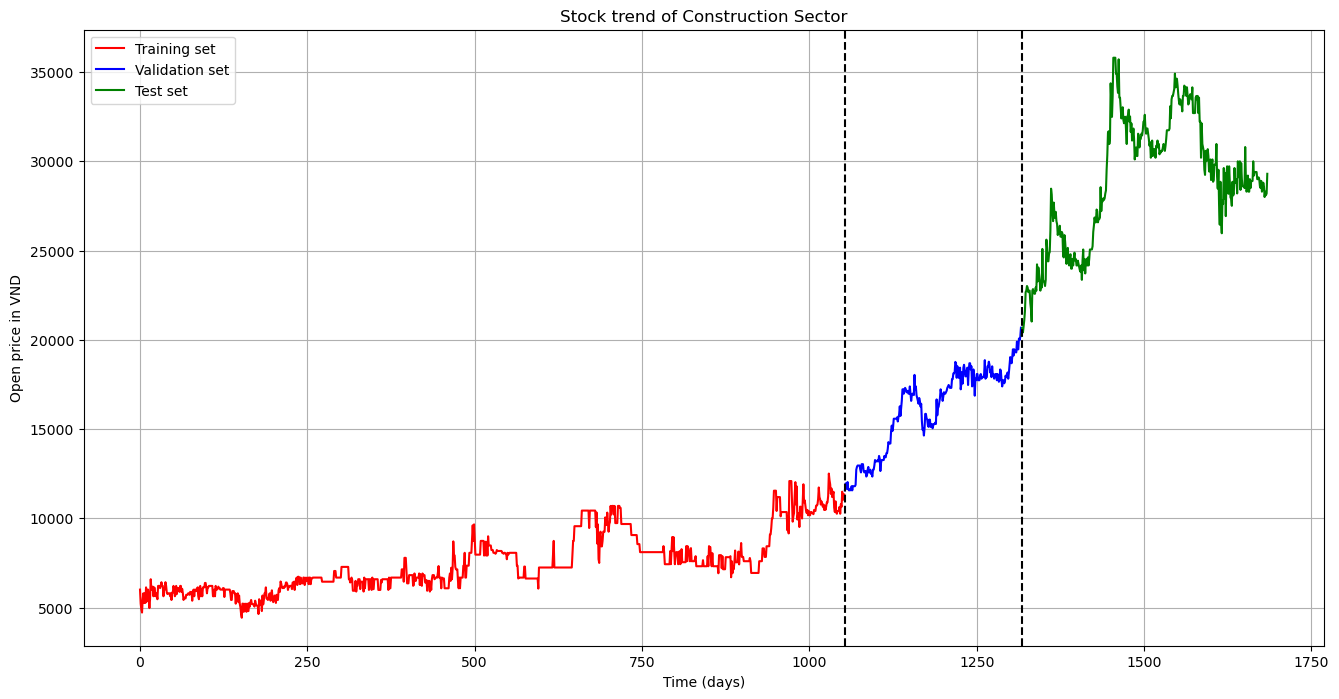

In [27]:
# Visualize the training, validation and test set
df_plot = df['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
fig = plt.figure(figsize=(16, 8)) # Change the figsize values as desired
ax = fig.add_subplot(111)
df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set', ax=ax)
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of Construction Sector")
plt.xlabel('Time (days)')
plt.ylabel('Open price in VND')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.grid() # Add grid
plt.show()

In [28]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    if max_feature - min_feature == 0:
        X_train_norm[i] = 0
        y_train_norm[i] = 0
    else:
        X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
        y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)


# MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
X_val_norm = X_val.copy()
y_val_norm = y_val.copy()
for i in range(0, len(X_val)):
    min_feature = np.min(X_val[i])
    max_feature = np.max(X_val[i])
    if max_feature - min_feature == 0:
        X_val_norm[i] = 0
        y_val_norm[i] = 0
    else:
        X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
        y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)


In [31]:
### Create and train the model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(30, 1), activation='relu'))  # LSTM layer with 128 units
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(LSTM(64, activation='relu'))  # LSTM layer with 64 units
model.add(Dense(32, activation='relu'))  # Dense layer with 32 units and ReLU activation
model.add(Dense(1))  # Dense output layer with 7 units

# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=20, batch_size=1024)

Epoch 1/20
2/2 [==============================] - 5s 596ms/step - loss: 0.4000 - mse: 0.4000 - val_loss: 0.5732 - val_mse: 0.5732
Epoch 2/20
2/2 [==============================] - 1s 224ms/step - loss: 0.3683 - mse: 0.3683 - val_loss: 0.5255 - val_mse: 0.5255
Epoch 3/20
2/2 [==============================] - 1s 136ms/step - loss: 0.3357 - mse: 0.3357 - val_loss: 0.4576 - val_mse: 0.4576
Epoch 4/20
2/2 [==============================] - 1s 135ms/step - loss: 0.2919 - mse: 0.2919 - val_loss: 0.3619 - val_mse: 0.3619
Epoch 5/20
2/2 [==============================] - 1s 260ms/step - loss: 0.2349 - mse: 0.2349 - val_loss: 0.2339 - val_mse: 0.2339
Epoch 6/20
2/2 [==============================] - 1s 150ms/step - loss: 0.1657 - mse: 0.1657 - val_loss: 0.1173 - val_mse: 0.1173
Epoch 7/20
2/2 [==============================] - 1s 158ms/step - loss: 0.1867 - mse: 0.1867 - val_loss: 0.1119 - val_mse: 0.1119
Epoch 8/20
2/2 [==============================] - 1s 153ms/step - loss: 0.1693 - mse: 0.16

In [32]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    if max_feature - min_feature == 0:
        X_test_norm[i] = 0
        y_test_norm[i] = 0
    else:
        X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
        y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [33]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

11/11 [==============================] - 1s 15ms/step
MSE on the test set:  0.0998835488517034


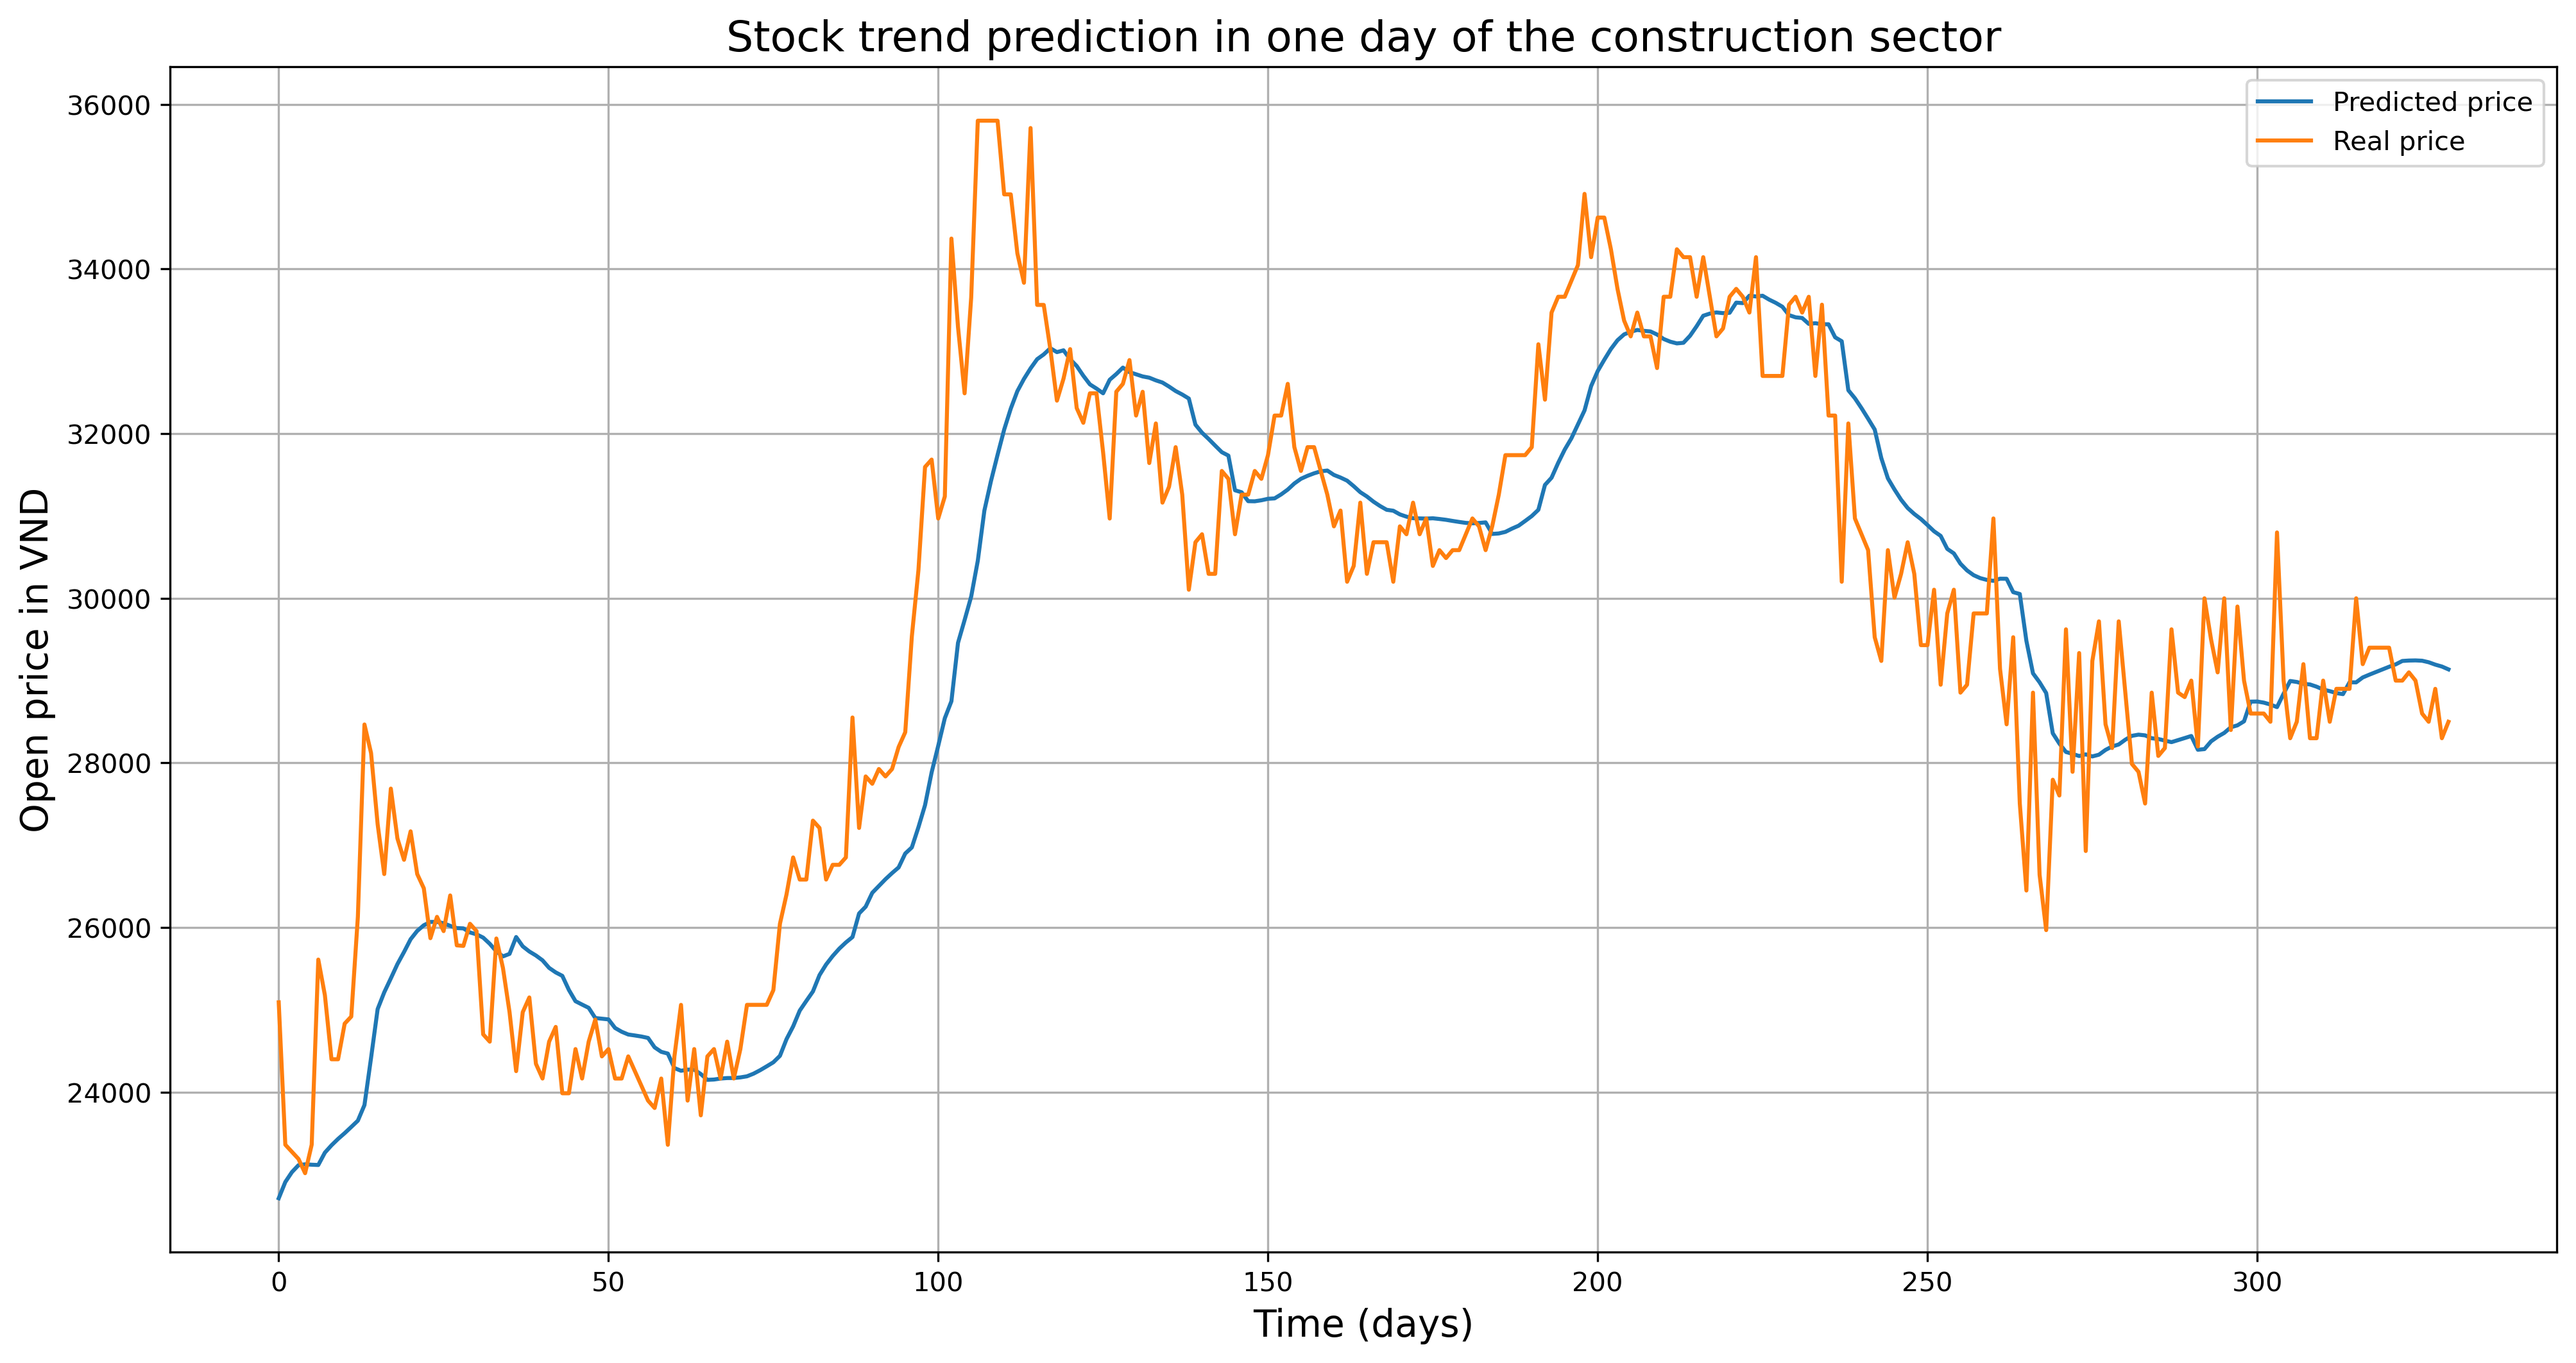

In [34]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day of the construction sector', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in VND', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()